In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from functions.make_plots import make_plots
from functions.rk import runge_kutta_4th_order as rk4
import matplotlib.pyplot as plt
from functions.interpolate import interpolator
import pandas as pd

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv("example_lat.csv")

# Extract the required columns
input_data = df[["Aileron", "Rudder"]]
states = df[["Side-slip angle deg", "Roll rate degs", "Yaw rate degs", "Roll deg"]]
t = df["Time"]


In [4]:
interpolate_trigger = 1
if interpolate_trigger == 1:
    interpolated_df = interpolator(t, input_data, states, desired_points=6000)
    input_data = interpolated_df[["Aileron", "Rudder"]]
    states = interpolated_df[["Side-slip angle deg", "Roll rate degs", "Yaw rate degs", "Roll deg"]]
    t = interpolated_df["Time"]

In [5]:
# Data to numpy array
t = t.to_numpy()
t = t-t[0]  # initialize time for plots
u_data = input_data.to_numpy()/3.1415*180  # r2d
z_data = states.to_numpy()*3.1415/180  # r2d
z_data = z_data

# Initialize state (helps with least squares approximation)
kz = z_data[0, :].copy()
ku = u_data[0, :].copy()
z_data = z_data-z_data[0, :]
u_data = u_data-u_data[0, :]
dt = t[5] - t[4]

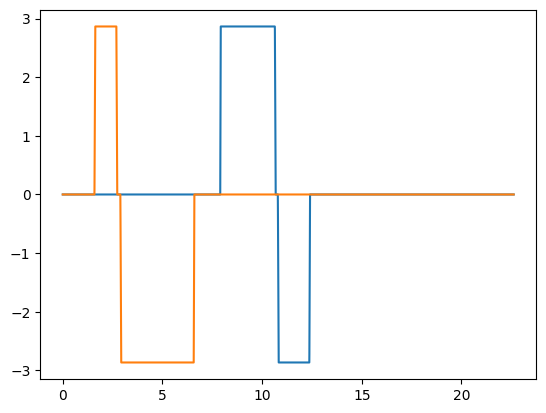

In [6]:
# Plot inputs
plt.plot(t, u_data)
plt.show()


In [7]:
# Calculate derivatives of the states
b_dot = np.gradient(z_data[:, 0], dt)  # Derivatives of beta
p_dot = np.gradient(z_data[:, 1], dt)  # Derivative of p
r_dot = np.gradient(z_data[:, 2], dt)  # Derivative of r
phi_dot = np.gradient(z_data[:, 3], dt)  # Derivative of phi | phi_dot = z_data[:, 1]


In [8]:
# Fit the linear model
X = np.concatenate((z_data, u_data), axis=1)
model = LinearRegression(fit_intercept=False)
model.fit(X, np.column_stack((b_dot, p_dot, r_dot, phi_dot)))


LinearRegression(fit_intercept=False)

In [9]:
# Get the estimated parameters
A = model.coef_[:, :4]
B = model.coef_[:, 4:]
# print("A:\n", np.array2string(A, suppress_small=True, precision=4, separator=', '))
# Fix known parameters
A[-1, :] = [0, 1, 0, 0]
A[[1, 2, 3], -1] = 0
B[-1, :] = 0

A:
 [[ -0.2298,  -0.0047,  -1.0078,   0.1538],
 [-23.5847,  -8.1908,   2.0032,   0.    ],
 [  7.2364,  -0.1374,  -1.0086,   0.    ],
 [  0.    ,   1.    ,   0.    ,   0.    ]]

B:
 [[-0.0001, -0.0002],
 [ 0.2423, -0.0249],
 [-0.0107,  0.0432],
 [ 0.    ,  0.    ]]


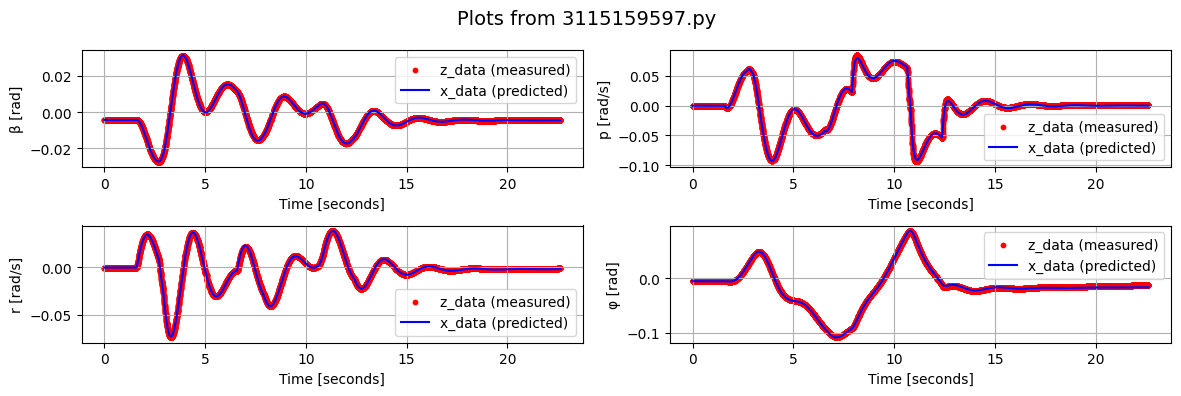

In [10]:
# Predict the output using the estimated parameters
x_data_p = np.zeros((len(t), 4))
for j in range(len(t) - 1):
    x_data_p[j + 1] = rk4(x_data_p[j], dt, u_data[j], u_data[j + 1], A, B)


# Plot the results
print("A:\n", np.array2string(A, suppress_small=True, precision=4, separator=', '))
print("\nB:\n", np.array2string(B, suppress_small=True, precision=4, separator=', '))
make_plots(t, z_data+kz, x_data_p+kz)  # +kz for initial values of the states
